In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load CSV File
df = pd.read_csv('/content/drive/MyDrive/Yamaha_cleaned.csv')
df1 = df.reset_index()['Price']

In [4]:
print(df)
df.describe()

            Date   Price    Open    High     Low    Volume  Change
0     04/01/2018  432000  421000  432000  420500  11600000    3850
1     05/01/2018  438000  434000  438500  431500   9426000    1390
2     09/01/2018  446500  441500  447000  437500   9687000    1940
3     10/01/2018  452000  447000  453000  446500   7640000    1230
4     11/01/2018  454000  452500  454500  451500   7968000     440
...          ...     ...     ...     ...     ...       ...     ...
1447  08/12/2023  321600  327100  327100  319900  14400000   -1680
1448  11/12/2023  321600  325900  326900  321300   9444000       0
1449  12/12/2023  317600  326900  327100  317400   9914000   -1240
1450  13/12/2023  321800  319000  323000  319000  10400000    1320
1451  14/12/2023  314200  320500  320500  313300  11100000   -2360

[1452 rows x 7 columns]


,Price,Open,High,Low,Volume,Change
count,1452.000000,1452.000000,1452.000000,1452.00000,1.452000e+03,1452.000000
mean,534245.110193,534465.840220,540058.057851,528327.61708,6.088632e+06,1.225895
std,69572.114292,69404.166264,69887.756992,68896.27649,3.185040e+06,2029.921662
min,314200.000000,319000.000000,320500.000000,313300.00000,1.144000e+06,-14570.000000
25%,493875.000000,494000.000000,499000.000000,489000.00000,4.071750e+06,-1132.500000
50%,531500.000000,532000.000000,537000.000000,526000.00000,5.324000e+06,0.000000
75%,577000.000000,579000.000000,584000.000000,572000.00000,7.116750e+06,1070.000000
max,744000.000000,745000.000000,749000.000000,736000.00000,3.140000e+07,12670.000000


In [5]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [6]:
# Split Train and Test Data
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
# Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
# Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 19ms/step - loss: 0.2670
Epoch 2/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0152
Epoch 3/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0068
Epoch 4/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0056
Epoch 5/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0047
Epoch 6/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0044
Epoch 7/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0040
Epoch 8/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0037
Epoch 9/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0036
Epoch 10/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0035
Epoch 11/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0039
Epoch 12/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0036
Epoch 13/100
13/13 [=====

In [11]:
# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 7ms/step


In [12]:
# Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [13]:
# Forecast Next 30 Days
last_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

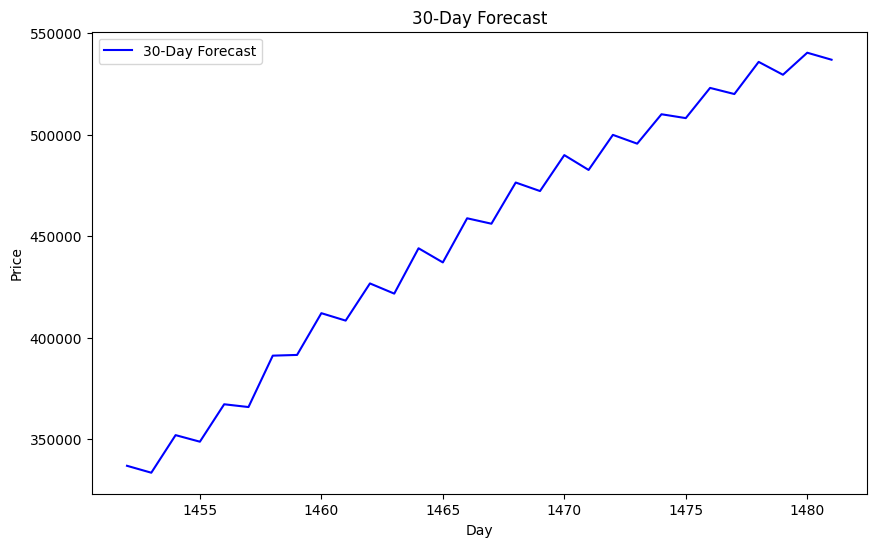

In [14]:
# Assuming 'lst_output' contains your 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)

# Plotting the 30-day forecast
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, color='blue')
plt.title('30-Day Forecast')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['30-Day Forecast'])
plt.show()

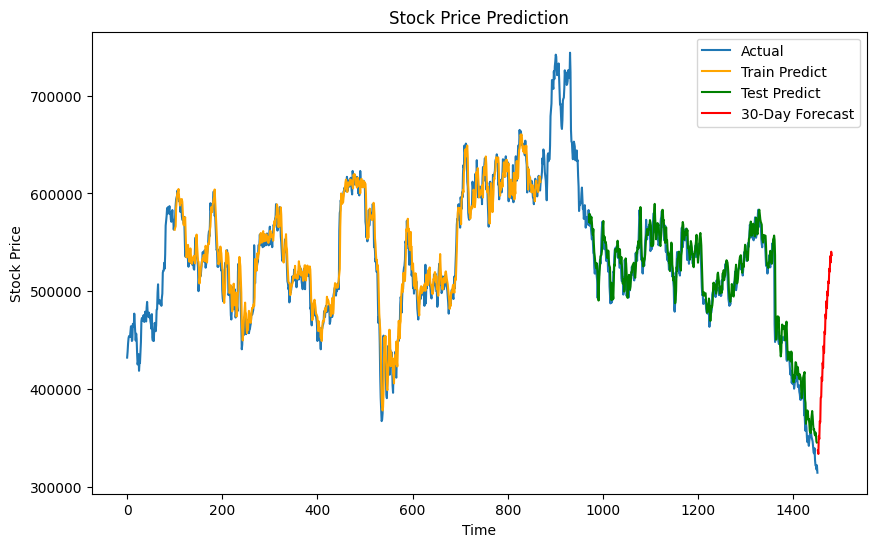

In [15]:
# Plot Results with Train and Test Predictions

plt.figure(figsize=(10, 6))

# Plot entire dataset
plt.plot(scaler.inverse_transform(df1), label='Actual')

# Plot training predictions
train_predict_plot = np.empty_like(df1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Train Predict', color='orange')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Test Predict', color='green')

# Plot 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, label='30-Day Forecast', color='red')

# Adding legends and labels
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Huber loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

# Compute Huber Loss
delta = 1.0  # You can adjust the delta parameter
test_huber_loss = np.mean(huber_loss(y_test_actual, test_predict, delta))
print('Testing Huber Loss:', test_huber_loss)

Testing RMSE: 14881.868159834872
Testing MAE: 11196.894856770834
Testing MAPE: 2.3250596016246172
Testing Huber Loss: 11196.394856770834
